# Distortion model training



In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import core
import config as cfg

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torch.utils.data.distributed
from pretorched import loggers

%load_ext autoreload
%autoreload 2

/home/camilo/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/camilo/.local/lib/python3.6/site-packages/tensorboard/compat/ten

In [15]:
class Args:
    dataset = "DFDC"
    data_root = '/home/camilo/Datasets/'
    arch = 'resnet3d50'
    model_name = 'FrameDetector'
    basemodel_name = 'efficientnet'
    segment_count = 16
    clip_length = 16
    frame_step = 5
    dataset_type = 'DeepfakeFaceVideo'
    record_set_type = 'DeepfakeFaceSet'
    sampler_type = 'TSNFrameSampler'
    pretrained = 'None'
    optimizer = 'Adam'
    scheduler = 'CosineAnnealingLR'
    init = 'ortho'
    test_split = None
    version = None
    num_workers = 12
    epochs = 100
    start_epoch = 0
    batch_size = 64
    lr = 0.001
    momentum = 0.9
    weight_decay = 1e-4
    print_freq = 10
    resume = ''
    weights_dir = 'weights'
    logs_dir = 'logs'
    results_dir = 'results'
    evaluate = False
    world_size = 1
    rank = 0
    dist_url = ''
    dist_backend = ''
    seed = None
    gpu = None
    ddp = False
    distributed = False
    
args = Args()

if args.data_root is None:
    args.data_root = cfg.DATA_ROOT
args.num_classes = cfg.num_classes_dict[args.dataset]

In [13]:
# Get model

save_name = core.name_from_args(args)
print(f'Starting: {save_name}')
    
model = core.get_model(
    args.model_name,
    args.basemodel_name,
    num_classes=args.num_classes,
    pretrained=args.pretrained,
    init_name=args.init,
)

input_size = model.input_size[-1]

Starting: FrameDetector_resnet18_dfdc_TSNFrameSampler_seg_count-16_init-None-ortho_optim-Adam_lr-0.001_sched-CosineAnnealingLR_bs-64
Initializing resnet18 with ortho.


In [14]:
# Prepare dataloaders

# Data loading code
dataloaders = core.get_dataloaders(
    args.dataset,
    args.data_root,
    dataset_type=args.dataset_type,
    record_set_type=args.record_set_type,
    sampler_type=args.sampler_type,
    segment_count=args.segment_count,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    distributed=args.distributed,
    size=input_size,
    clip_length=args.clip_length,
    frame_step=args.frame_step,
)


train_loader, val_loader = dataloaders['train'], dataloaders['val']
train_sampler = train_loader.sampler



In [10]:
# Create dataparallel to work on all available GPUs

# model = torch.nn.DataParallel(model).cuda()
model = model.cuda()
criterion = nn.CrossEntropyLoss().cuda()

optimizer = core.get_optimizer(
    model,
    args.optimizer,
    lr=args.lr,
    momentum=args.momentum,
    weight_decay=args.weight_decay,
)

scheduler = core.get_scheduler(optimizer, args.scheduler)

cudnn.benchmark = True

logger = loggers.TensorBoardLogger(
    args.logs_dir, name=save_name, rank=args.rank, version=args.version
)


Training - Epoch 0


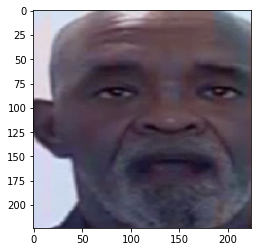

TypeError: cuda(): argument 'device' (position 1) must be torch.device, not list

In [11]:
# Training

from main import train

for epoch in range(args.start_epoch, args.epochs):
    if args.distributed:
        train_sampler.set_epoch(epoch)

    display = True # is_rank0(args, ngpus_per_node)

    # Train for one epoch.
    print("Training - Epoch %d" % epoch)
    train_acc1, train_loss = train(train_loader, 
                                   model, 
                                   criterion, 
                                   optimizer, 
                                   logger, 
                                   epoch, 
                                   args, 
                                   display)

    history['acc'].append(train_acc1.item())
    history['loss'].append(train_loss)
    print("Train - Acc: %.3f. Loss: %.3f" % (train_acc1.item(), train_loss))
    # Evaluate on validation set.
    val_acc1, val_loss = validate(val_loader, model, criterion, args, display)

    history['val_acc'].append(val_acc1)
    history['val_loss'].append(val_loss)
    history['epoch'].append(epoch + 1)

    logger.log_metrics(
        {
            'EpochAccuracy/train': train_acc1,
            'EpochLoss/train': train_loss,
            'EpochAccuracy/val': val_acc1,
            'EpochLoss/val': val_loss,
        },
        step=epoch + 1,
    )

    # Update the learning rate.
    if type(scheduler).__name__ == 'ReduceLROnPlateau':
        scheduler.step(val_loss)
    else:
        scheduler.step()

    # remember best acc@1 and save checkpoint
    is_best = val_acc1 > best_acc1
    best_acc1 = max(val_acc1, best_acc1)

#     if is_rank0(args, ngpus_per_node):
    save_checkpoint(
        {
            'epoch': epoch + 1,
            'arch': args.arch,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer': optimizer.state_dict(),
            'history': history,
            'args': args,
        },
        is_best,
        filename=os.path.join(args.weights_dir, save_name),
    )

    with open(args.log_file, 'w') as f:
        json.dump(history, f, indent=4)
